<a href="https://colab.research.google.com/github/IshtarMM/Practical_Course/blob/master/MicrobiomeDataAnalysis_KemenLab_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">

   <td>
    <a target="_blank" href="https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/zentren/zentrum-fuer-molekularbiologie-der-pflanzen/research/mikrobielle-interaktionen/gruppe/"><img src="https://uni-tuebingen.de/fileadmin/_processed_/f/a/csm_IMG_4015_35e7b6c800.jpg"width="30" height="30"/> Kemen lab</a>
  </td>
</table>

##**In this notebook we are going to do some analysis of amplicon seuqencing data.**

Look at the following picture to get some idea of the steps.

**A**: Sequencing and Preprocessing

**B**: Generate OTU/ASV tables and taxonomy files

**C**: Analysis: Diversity of microbes, association between microbes (networks), prediction of different status and finding important microbes in prediction (machines learning)

<table class="tfo-notebook-buttons" align="left">

  <td>
    <a target="_blank" href="https://github.com/IshtarMM/Practical_Course"><img src="https://github.com/IshtarMM/Practical_Course/blob/master/Presentation1%20copy.png?raw=true" /></a>
  </td>
</table>

Check to see if R scripts are working (if not run the next command).

In [2]:
print("Hello World", quote = FALSE)
getwd()

[1] Hello World


[1] "/content"

In [9]:
dir_path <- "./Practical_Course"

unlink(dir_path, recursive=TRUE)

Load the dataset from GitHub

In [10]:
shell_call <- function(command, ...) {              #Declares shell_call fucntion with "command parameter" and (...) for additional arguments
  result <- system(command, intern = TRUE, ...)     #Calls system fucntion with command argument; "intern" instructs the system to capture the output as a vector and stores it in "result"
  cat(paste0(result, collapse = "\n"))              #paste0 concatenates (verknüpft) the elemtns of the "result" vector into a single character string separated by newline; "cat" prints the string to the console
}

shell_call("git clone https://github.com/IshtarMM/Practical_Course") #Clones the GitHub repository here


In [11]:
load("Practical_Course/files.RData")                                                  #Loads the file "files.RData"
ls()                                                                                  #Lists all objects currebtly in the R environment

[1] "data"       "dir_path"   "metadata"   "shell_call" "taxonomy"

Where does the dataset come from and what does it contain?

Samples were taken from *Arabidopsis thaliana* plants in the wild.
<table>
  <tr>
    <td> <img src="https://github.com/IshtarMM/Practical_Course/blob/master/pic/IMGAra1.jpg?raw=true" height=300 /> </td>
    <td> <img src="https://github.com/IshtarMM/Practical_Course/blob/master/pic/Picture%202.png?raw=true" height=400 /> </td>
  </tr>
</table>

Left: *A. thaliana* plants growing on a natural site.

Right: Leaf surface of *A. thaliana* plant with a fungus and bacteria.

Samples were taken over several years and seasons. Microbes on the surface of the plant leaves (Epiphytes) and microbes inside the same plant leaves (Endophytes) were analysed.

<img src="https://github.com/IshtarMM/Practical_Course/blob/master/pic/pic4.jpg?raw=true" height=400 />

Plants were further phenotypically screened for infection by the protist pathogen *Albugo laibachii*, the causal agent of white blister rust.

<img src="https://github.com/IshtarMM/Practical_Course/blob/master/pic/pic5.png?raw=true" height=400/>




Now let's take a closer look at the structure of the dataset.

In [12]:
head(data)    #Displays the first few rows of the "data" object

,ID,Otu000002,Otu000003,Otu000004,Otu000005,Otu000006,Otu000009,Otu000010,Otu000011,Otu000012,⋯,Otu002106,Otu002107,Otu002108,Otu002109,Otu002110,Otu002111,Otu002112,Otu002113,Otu002114,Otu002115
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
S324,S324,879,1632,22,5,20,678,546,0,1,⋯,0,0,0,3,0,0,0,0,0,0
S164,S164,4410,1123,82,1087,7691,2096,1480,84,0,⋯,0,0,0,0,0,0,0,0,0,0
S400,S400,206,4,32232,0,184,145,21,7,0,⋯,0,0,0,1,0,0,0,0,0,0
S346,S346,230,179,1363,259,1,1969,123,46,6663,⋯,0,0,0,0,0,0,0,0,0,0
S145,S145,45,148,2960,134,21187,0,12,18,1,⋯,0,0,0,0,0,0,0,0,0,0
S568,S568,2654,136,8759,214,415,5556,1334,199,0,⋯,0,0,0,0,0,0,0,0,0,0


How many samples and OTUs are in the data?

In [13]:
print(paste("Number of samples: ", nrow(data)))       #"nrow" returns the number of rows in "data"
print(paste("Number of OTUs: ", ncol(data)-1))        #"ncol" returns the number of columns in "data"; "-1" tells the script to start one column lower -> Otherwise the headers will be counted too

[1] "Number of samples:  699"
[1] "Number of OTUs:  1899"


Information of samples

In [14]:
colnames(metadata) = c("ID", "Compartment", "Year", "Season", "Infection_Stage")    #Edit the column names in the data frame "metadata"
head(metadata)

,ID,Compartment,Year,Season,Infection_Stage
,<chr>,<chr>,<int>,<chr>,<chr>
S324,S324,Endo,2016,Fall,Infected
S164,S164,Endo,2016,Spring,Healthy
S400,S400,Endo,2017,Spring,Infected
S346,S346,Endo,2016,Fall,Healthy
S145,S145,Endo,2014,Spring,Infected
S568,S568,Endo,2018,Spring,Healthy


How many samples are collected in spring?

In [15]:
table(metadata$Season)                          #Creates a table using only the Season information from metadata


  Fall Spring 
   313    386 

How many of the fall samples are endophytic?

In [16]:
table(metadata$Season, metadata$Compartment)    #Creates a table consisting of Season and Compartment information

        
         Endo Epi
  Fall    156 157
  Spring  192 194

##<font color="red">**Question 1:**</font>

How many infected samples were collected in spring of 2016?

In [ ]:
#Type your answer here

Let's use the taxonomy file, where "Size" is the number of reads of each OTU in all of the samples.

In [17]:
head(taxonomy)

,OTU,Size,Taxonomy,Kingdom,Phylum,Class,Order,Family,Genus
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Otu000002,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
2,Otu000003,291965,Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Methylobacterium-Methylorubrum;,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Beijerinckiaceae,Methylobacterium-Methylorubrum
3,Otu000004,286108,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Duganella;,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Oxalobacteraceae,Duganella
4,Otu000005,275753,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas
5,Otu000006,272764,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas
6,Otu000009,197946,Bacteria;Bacteroidota;Bacteroidia;Flavobacteriales;Flavobacteriaceae;Flavobacterium;,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Flavobacteriaceae,Flavobacterium


---
##>Now let's plot the total number of reads per sample of each year from the OTU table.

First we have to install some packages that we use in R for data visualization.

In [ ]:
install.packages("ggplot2")     #Installs the package "ggplot2"
install.packages("plotly")      #Installs the package "plotly"
library(ggplot2)                #Loads the package "ggplot2" into our current environment
library(plotly)                 #Loads the package "plotly" into our current environment

Now we create the plot.

,ID,Otu000002,Otu000003,Otu000004,Otu000005,Otu000006,Otu000009,Otu000010,Otu000011,Otu000012,⋯,Otu002106,Otu002107,Otu002108,Otu002109,Otu002110,Otu002111,Otu002112,Otu002113,Otu002114,Otu002115
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
S324,S324,879,1632,22,5,20,678,546,0,1,⋯,0,0,0,3,0,0,0,0,0,0
S164,S164,4410,1123,82,1087,7691,2096,1480,84,0,⋯,0,0,0,0,0,0,0,0,0,0
S400,S400,206,4,32232,0,184,145,21,7,0,⋯,0,0,0,1,0,0,0,0,0,0
S346,S346,230,179,1363,259,1,1969,123,46,6663,⋯,0,0,0,0,0,0,0,0,0,0
S145,S145,45,148,2960,134,21187,0,12,18,1,⋯,0,0,0,0,0,0,0,0,0,0
S568,S568,2654,136,8759,214,415,5556,1334,199,0,⋯,0,0,0,0,0,0,0,0,0,0


,Otu000002,Otu000003,Otu000004,Otu000005,Otu000006,Otu000009,Otu000010,Otu000011,Otu000012,Otu000013,⋯,Otu002106,Otu002107,Otu002108,Otu002109,Otu002110,Otu002111,Otu002112,Otu002113,Otu002114,Otu002115
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
S324,879,1632,22,5,20,678,546,0,1,554,⋯,0,0,0,3,0,0,0,0,0,0
S164,4410,1123,82,1087,7691,2096,1480,84,0,471,⋯,0,0,0,0,0,0,0,0,0,0
S400,206,4,32232,0,184,145,21,7,0,3,⋯,0,0,0,1,0,0,0,0,0,0
S346,230,179,1363,259,1,1969,123,46,6663,1877,⋯,0,0,0,0,0,0,0,0,0,0
S145,45,148,2960,134,21187,0,12,18,1,0,⋯,0,0,0,0,0,0,0,0,0,0
S568,2654,136,8759,214,415,5556,1334,199,0,286,⋯,0,0,0,0,0,0,0,0,0,0


,Otu000002,Otu000003,Otu000004,Otu000005,Otu000006,Otu000009,Otu000010,Otu000011,Otu000012,Otu000013,⋯,Otu002107,Otu002108,Otu002109,Otu002110,Otu002111,Otu002112,Otu002113,Otu002114,Otu002115,ReadSumPerSample
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
S324,879,1632,22,5,20,678,546,0,1,554,⋯,0,0,3,0,0,0,0,0,0,56563
S164,4410,1123,82,1087,7691,2096,1480,84,0,471,⋯,0,0,0,0,0,0,0,0,0,36243
S400,206,4,32232,0,184,145,21,7,0,3,⋯,0,0,1,0,0,0,0,0,0,34337
S346,230,179,1363,259,1,1969,123,46,6663,1877,⋯,0,0,0,0,0,0,0,0,0,29516
S145,45,148,2960,134,21187,0,12,18,1,0,⋯,0,0,0,0,0,0,0,0,0,28638
S568,2654,136,8759,214,415,5556,1334,199,0,286,⋯,0,0,0,0,0,0,0,0,0,27926


,Row.names,Year,ReadSumPerSample
,<I<chr>>,<int>,<dbl>
1,S1,2014,15787
2,S10,2014,21633
3,S100,2014,13152
4,S101,2014,452
5,S102,2014,1418
6,S103,2015,1493


,Group.1,x
,<int>,<dbl>
1,2014,1538676
2,2015,1384795
3,2016,1821900
4,2017,1166472
5,2018,1045870
6,2019,545126


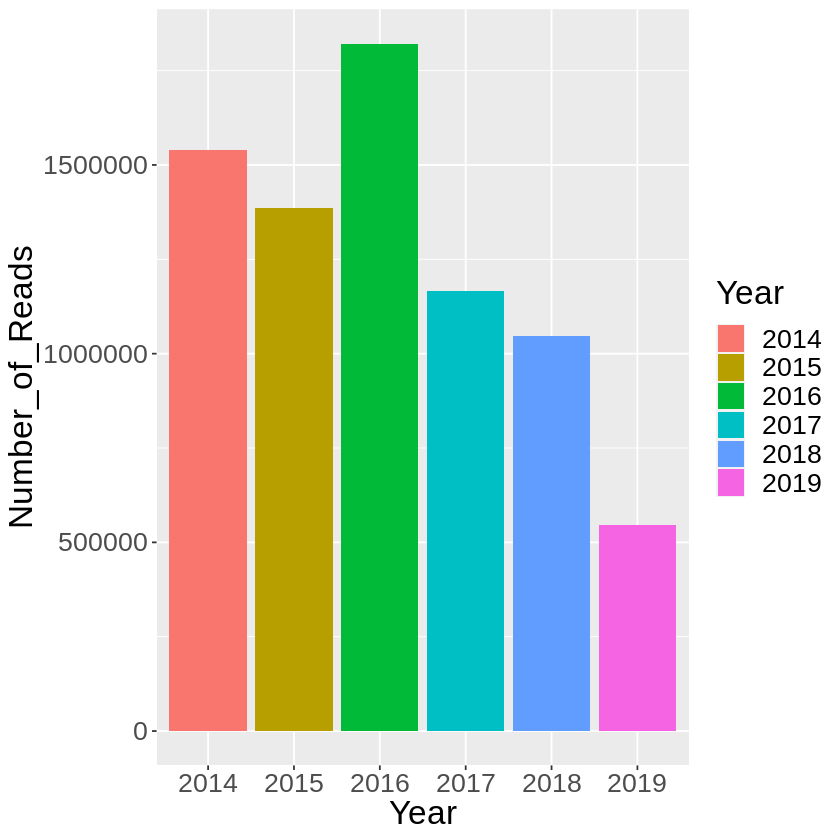

In [19]:
head(data)                            #For comparison we look at the original file again
tab <- data[-c(1)]                    #Creates a new object which contains all data from "data", except from the first column
head(tab)
tab$ReadSumPerSample <- rowSums(tab)   #Calculates the sum or rows in "tab" and then assigns this to a new colum named "ReadSumPerSample"
head(tab)
tab_sample <- merge(metadata["Year"], tab["ReadSumPerSample"], by = "row.names") #Creates a new data frame which uses "Year" from "metadata" and "RedSumPerTable" from "tab"
head(tab_sample)
agg_tab <- aggregate(tab_sample[,3], list(tab_sample$Year), sum) #Aggregates the data from the second column from "tab_sample" by Year -> New data frame shows the number of reads per year
head(agg_tab)
colnames(agg_tab) <- c("Year", "Number_of_Reads")
agg_tab$Year <- as.factor(agg_tab$Year)                           #Defines the column "Year" as a factor, so a numeric value

#Let's plot it now!
ggplot() + geom_bar(data=agg_tab, aes(x=Year, y=Number_of_Reads, fill=Year), stat = "identity") + theme(text = element_text(size=20))

A CHEAT SHEET to better understand and use ggplot2 can be found here: [open CHEAT SHEET](https://drive.google.com/file/d/1pPZdUGQqfwDOEY7xY7Uw4o6siYVDIORj/view?usp=sharing).
More can be found here: https://ggplot2.tidyverse.org/.

##<font color="red">**Question 2:**</font>

What is the max, min and average number of reads per sample?

In [ ]:
#Type your answer here
#hint: use functions in R such as max()

##>Now let's see the number of reads per OTU in each sample (for the first 5 samples).

In [20]:
install.packages("reshape2")
library(reshape2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




Create a new data frame "ra_tab", which contains everything from "data", except for the first column.

Then select the first 5 rows of "ra_tab" and assign them back to "ra_tab".

Last, add the rowname "ID" to the data frame which uses the rownames from "ra_tab".

In [21]:
ra_tab <- data[-c(1)]                   #Creates a new object which contains all data from "data", except from the first column
ra_tab <- ra_tab[1:5,]                  #This selects the first 5 rows of "ra_tab" and assigns them back to "ra_tab", "," indicates all columns to be included
ra_tab$ID <- rownames(ra_tab)           #Adds the row name "ID" to the data frame which uses the rownames from "ra_tab"
head(ra_tab)

,Otu000002,Otu000003,Otu000004,Otu000005,Otu000006,Otu000009,Otu000010,Otu000011,Otu000012,Otu000013,⋯,Otu002107,Otu002108,Otu002109,Otu002110,Otu002111,Otu002112,Otu002113,Otu002114,Otu002115,ID
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
S324,879,1632,22,5,20,678,546,0,1,554,⋯,0,0,3,0,0,0,0,0,0,S324
S164,4410,1123,82,1087,7691,2096,1480,84,0,471,⋯,0,0,0,0,0,0,0,0,0,S164
S400,206,4,32232,0,184,145,21,7,0,3,⋯,0,0,1,0,0,0,0,0,0,S400
S346,230,179,1363,259,1,1969,123,46,6663,1877,⋯,0,0,0,0,0,0,0,0,0,S346
S145,45,148,2960,134,21187,0,12,18,1,0,⋯,0,0,0,0,0,0,0,0,0,S145


Now, transform the newly created data frame into a format which R can more easily use. This is done by creating a new data frame from "ra_tab", which has one row for each OTU.

In [22]:
melt_tab <- melt(ra_tab)                           #The melt() function transforms the data frame from a wide format, where each column represents a variable, to a long format, where each variable is stacked in a single column.
colnames(melt_tab) = c("ID", "OTU", "Abundance")
head(melt_tab)

Using ID as id variables



,ID,OTU,Abundance
,<chr>,<fct>,<int>
1,S324,Otu000002,879
2,S164,Otu000002,4410
3,S400,Otu000002,206
4,S346,Otu000002,230
5,S145,Otu000002,45
6,S324,Otu000003,1632


Next, we merge "melt_tab" with the "taxonomy" data frame provided to create a data frame which contains the ID, OTU name and abundance from "melt_tab" as well as the taxonomic information from "taxonomy".

In [23]:
head(taxonomy)
tab_taxa <- merge(x=melt_tab, y=taxonomy, by.x ="OTU", by.y="OTU")    #Merges "melt_tab" and "taxonomy" based on OTU column
head(tab_taxa)

,OTU,Size,Taxonomy,Kingdom,Phylum,Class,Order,Family,Genus
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Otu000002,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
2,Otu000003,291965,Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Methylobacterium-Methylorubrum;,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Beijerinckiaceae,Methylobacterium-Methylorubrum
3,Otu000004,286108,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Duganella;,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Oxalobacteraceae,Duganella
4,Otu000005,275753,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas
5,Otu000006,272764,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas
6,Otu000009,197946,Bacteria;Bacteroidota;Bacteroidia;Flavobacteriales;Flavobacteriaceae;Flavobacterium;,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Flavobacteriaceae,Flavobacterium


,OTU,ID,Abundance,Size,Taxonomy,Kingdom,Phylum,Class,Order,Family,Genus
,<fct>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Otu000002,S324,879,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
2,Otu000002,S164,4410,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
3,Otu000002,S400,206,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
4,Otu000002,S346,230,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
5,Otu000002,S145,45,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
6,Otu000003,S324,1632,291965,Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Methylobacterium-Methylorubrum;,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Beijerinckiaceae,Methylobacterium-Methylorubrum


Let's modify the newly created data frame a bit! First we create a new coulmn named "OTU_Genus" by combining values from the "OTU" and "Genus" column using an underscore character. Then we rename each Taxa with an abundance <= 1000 to "Other" and reorder the categories in the "OTU_Genus" column based on abundance.

In [24]:
tab_taxa$OTU_Genus = paste(tab_taxa$OTU, tab_taxa$Genus, sep = "_")   #This creates a new column named "OTU_Genus" in the tab_taxa data frame by combining values from the "OTU" and "Genus" columns with an underscore separator.
tab_taxa$OTU_Genus[tab_taxa$Abundance <= 1500] <- "Other"             #Renames each Taxa with an abundance <= 1000 to "Other"
tab_taxa$OTU_Genus <- reorder(tab_taxa$OTU_Genus, tab_taxa$Abundance) #Reorders the levels or categories in the "OTU_Genus" column of the tab_taxa data frame based on the values in the "Abundance" column
head(tab_taxa)

,OTU,ID,Abundance,Size,Taxonomy,Kingdom,Phylum,Class,Order,Family,Genus,OTU_Genus
,<fct>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
1,Otu000002,S324,879,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,Other
2,Otu000002,S164,4410,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,Otu000002_Sphingomonas
3,Otu000002,S400,206,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,Other
4,Otu000002,S346,230,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,Other
5,Otu000002,S145,45,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,Other
6,Otu000003,S324,1632,291965,Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Methylobacterium-Methylorubrum;,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Beijerinckiaceae,Methylobacterium-Methylorubrum,Otu000003_Methylobacterium-Methylorubrum


To create a data frame with even more information, we add information from the provided "metadata" file. We do this by "ID", as this is our common identifier here.

In [25]:
tab_taxa1 <- merge(x=tab_taxa, metadata, by="ID")
tab_taxa1$Year = as.factor(tab_taxa1$Year)
head(tab_taxa1)

,ID,OTU,Abundance,Size,Taxonomy,Kingdom,Phylum,Class,Order,Family,Genus,OTU_Genus,Compartment,Year,Season,Infection_Stage
,<chr>,<fct>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<fct>,<chr>,<chr>
1,S145,Otu000172,1,7452,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Massilia;,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Oxalobacteraceae,Massilia,Other,Endo,2014,Spring,Infected
2,S145,Otu000638,0,1569,Bacteria;Actinobacteriota;Actinobacteria;Pseudonocardiales;Pseudonocardiaceae;Pseudonocardia;,Bacteria,Actinobacteriota,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Pseudonocardia,Other,Endo,2014,Spring,Infected
3,S145,Otu000173,0,7403,Bacteria;Actinobacteriota;Acidimicrobiia;Microtrichales;Iamiaceae;Iamia;,Bacteria,Actinobacteriota,Acidimicrobiia,Microtrichales,Iamiaceae,Iamia,Other,Endo,2014,Spring,Infected
4,S145,Otu000667,0,1476,Bacteria;Chloroflexi;Chloroflexia;Chloroflexales;Chloroflexaceae;Chloroflexaceae_unclassified;,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Chloroflexaceae,Chloroflexaceae_unclassified,Other,Endo,2014,Spring,Infected
5,S145,Otu000668,0,1474,Bacteria;Actinobacteriota;Actinobacteria;Pseudonocardiales;Pseudonocardiaceae;Actinomycetospora;,Bacteria,Actinobacteriota,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Actinomycetospora,Other,Endo,2014,Spring,Infected
6,S145,Otu000669,0,1470,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Atopobiaceae;Atopobium;,Bacteria,Actinobacteriota,Coriobacteriia,Coriobacteriales,Atopobiaceae,Atopobium,Other,Endo,2014,Spring,Infected


Now let's finally plot the number of reads per OTU for the first 5 samples.

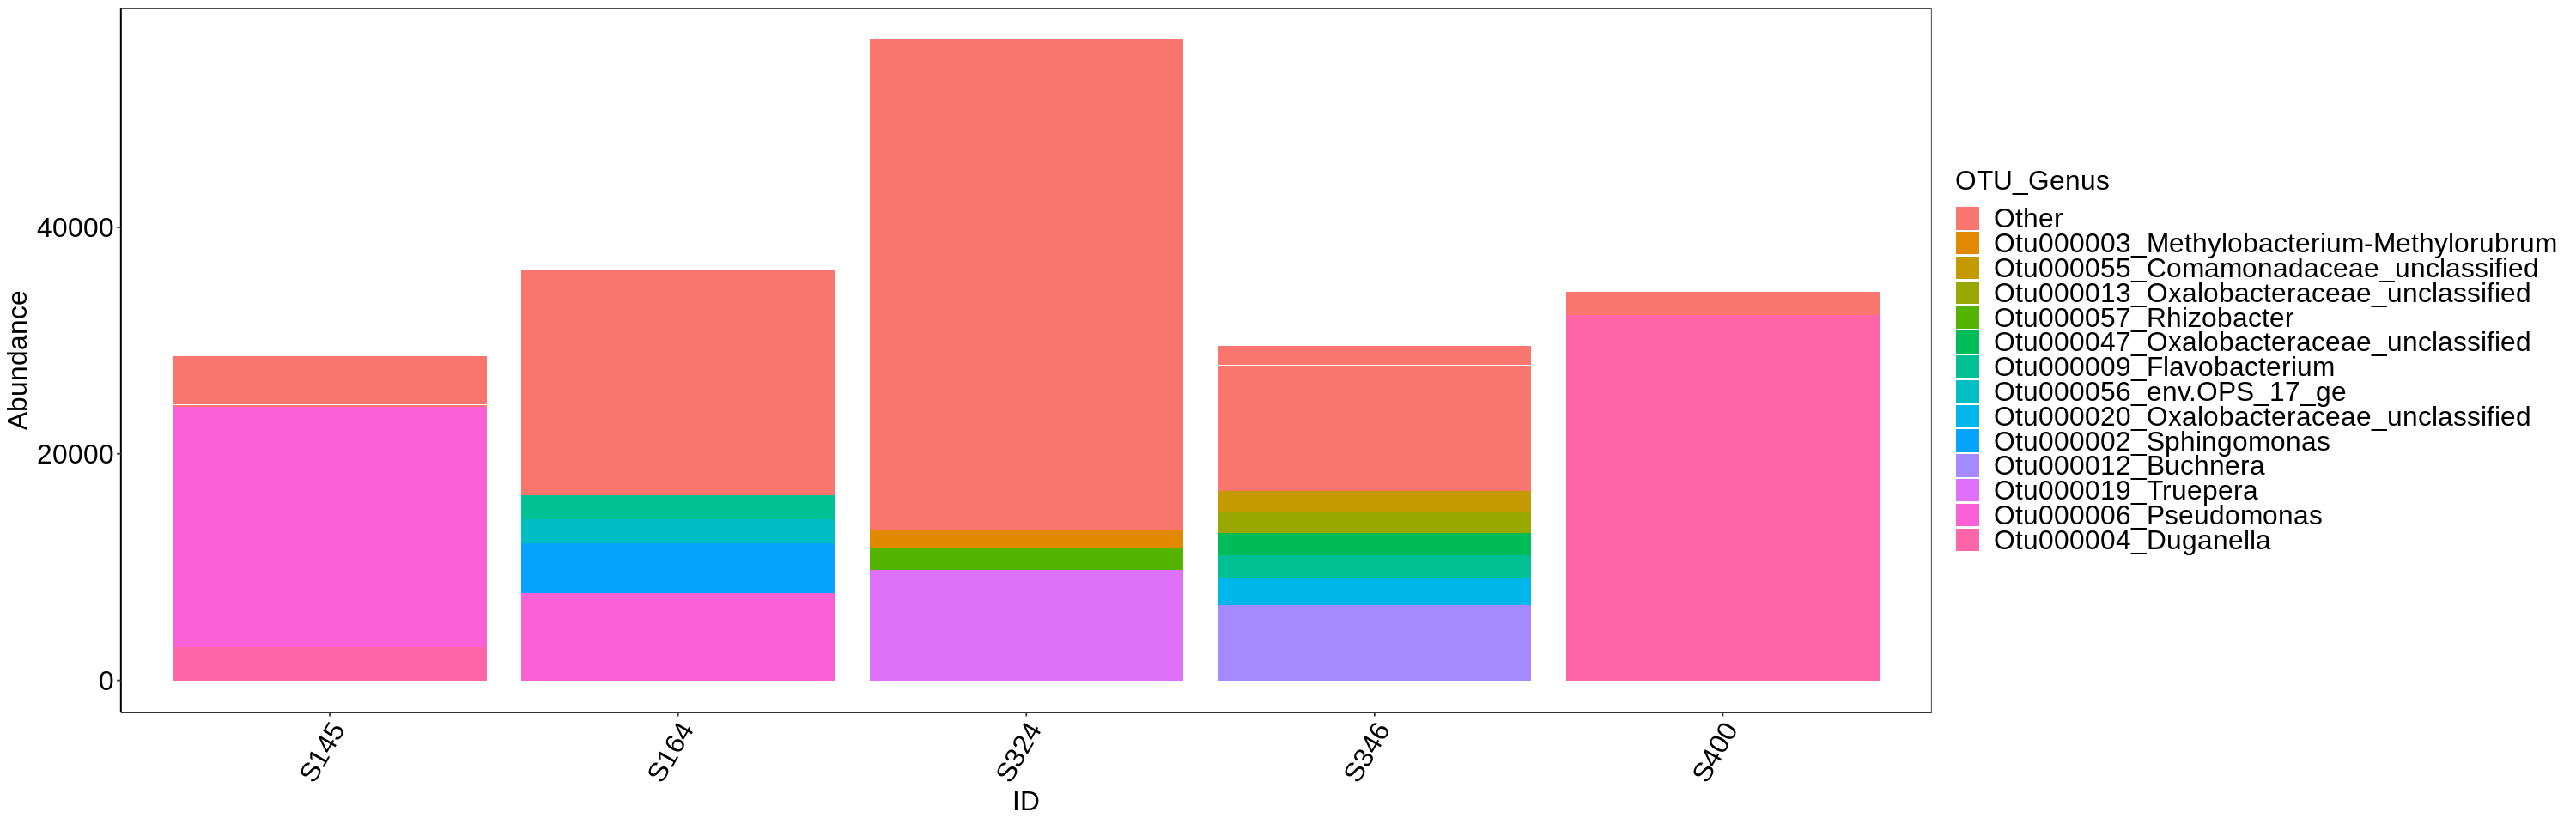

In [26]:
dir.create("plots")      #Create a new directory named "plots"
#Create a plot where we show the number of reads per OTU in the first 5 samples plus some beautification
p2 <- ggplot() + geom_bar(data=tab_taxa1, aes(x=ID, y=Abundance, fill=OTU_Genus), stat="identity") + scale_color_brewer("Dark2") +
  theme_bw() + theme(text = element_text(size = 19, color = "black"),
                       axis.text = element_text(size = 19 , colour = "black" ),
                       axis.title = element_text(size = 19 , colour = "black" ),
                       strip.text = element_text(size = 19 , colour = "black" ),
                       axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 19),
                       panel.grid.major = element_blank(),
                       panel.grid.minor = element_blank(),
                       axis.line = element_line(colour = "black") ,
                       legend.title = element_text(color = "black", size = 19),
                       legend.text = element_text(color = "black", size = 19) ,
                       strip.background = element_rect(colour = "black", fill = "white"))

htmlwidgets::saveWidget(ggplotly(p2), "plots/AbundanceOTU.html")    #Saves the plot as a ".html" file to open it in the browser
ggsave("plots/AbundanceOTU.png", p2, device = "png", width=15, height=8)

options(repr.plot.width=25, repr.plot.height=8)                     #Sets global width and height for plots in Jupyter Notebook
p2                                                                  #Show plot

##<font color="red">**Question 3:**</font>

What are the most abundant OTUs in each of the samples?

-> Open the plot in plots folder.

In [ ]:
#Type your answer here

##>Does it makes sense to compare samples without normalization?

How can we normalize the data to compare the samples?

Normalization approaches for microbiome data:

1. Rarefying: Subsample taxa without replacement so that all samples have the same library size
2. Proportion (Relative abundance): Counts are divided by total library size (Scaling between 0 and 1)

Let's visualize the previous plot on a normalized table (Relative abundance).

In [27]:
install.packages("vegan")
library(vegan)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘permute’


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



In [28]:
#We basically do the same as before but with a standardized "ra_tab"
ra_tab <- decostand(data[-c(1)], method="total", MARGIN=1) #This returns a standardized data frame. Standardization, as contrasted to transformation, means that the entries are transformed relative to other entries.
#"total": Standardize the remaining columns, "MARGIN=1": Apply standardization row-wise
head(ra_tab)

,Otu000002,Otu000003,Otu000004,Otu000005,Otu000006,Otu000009,Otu000010,Otu000011,Otu000012,Otu000013,⋯,Otu002106,Otu002107,Otu002108,Otu002109,Otu002110,Otu002111,Otu002112,Otu002113,Otu002114,Otu002115
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S324,0.015540194,0.0288527836,0.0003889468,8.839701e-05,3.535880e-04,0.01198663,0.0096529533,0.0000000000,1.767940e-05,9.794389e-03,⋯,0,0,0,5.303821e-05,0,0,0,0,0,0
S164,0.121678669,0.0309852937,0.0022625059,2.999200e-02,2.122065e-01,0.05783186,0.0408354717,0.0023176889,0.000000e+00,1.299561e-02,⋯,0,0,0,0.000000e+00,0,0,0,0,0,0
S400,0.005999359,0.0001164924,0.9386958674,0.000000e+00,5.358651e-03,0.00422285,0.0006115852,0.0002038617,0.000000e+00,8.736931e-05,⋯,0,0,0,2.912310e-05,0,0,0,0,0,0
S346,0.007792384,0.0060645074,0.0461783439,8.774902e-03,3.387993e-05,0.06670958,0.0041672313,0.0015584768,2.257420e-01,6.359263e-02,⋯,0,0,0,0.000000e+00,0,0,0,0,0,0
S145,0.001571339,0.0051679587,0.1033591731,4.679098e-03,7.398212e-01,0.00000000,0.0004190237,0.0006285355,3.491864e-05,0.000000e+00,⋯,0,0,0,0.000000e+00,0,0,0,0,0,0
S568,0.095036883,0.0048700136,0.3136503617,7.663110e-03,1.486070e-02,0.19895438,0.0477691041,0.0071259758,0.000000e+00,1.024135e-02,⋯,0,0,0,0.000000e+00,0,0,0,0,0,0


In [29]:
#Now we do the same as before with ra_tab, but keep in mind now we have the standardized abundance
ra_tab <- ra_tab[1:5,]
ra_tab$ID <- rownames(ra_tab)
melt_tab <- melt(ra_tab)
colnames(melt_tab) = c("ID","OTU","RelativeAbundance")
tab_taxa <- merge(x =melt_tab , y = taxonomy , by.x  = "OTU" , by.y = "OTU")
tab_taxa$OTU_Genus = paste(tab_taxa$OTU , tab_taxa$Genus , sep = "_")
tab_taxa$OTU_Genus[tab_taxa$RelativeAbundance <= 0.03] <- "Other"
tab_taxa$OTU_Genus <- reorder(tab_taxa$OTU_Genus , tab_taxa$RelativeAbundance)
tab_taxa1 <- merge(x =tab_taxa  , y = metadata, by = "ID")
tab_taxa1$Year = as.factor(tab_taxa1$Year)
head(tab_taxa1)

Using ID as id variables



,ID,OTU,RelativeAbundance,Size,Taxonomy,Kingdom,Phylum,Class,Order,Family,Genus,OTU_Genus,Compartment,Year,Season,Infection_Stage
,<chr>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<fct>,<chr>,<chr>
1,S145,Otu000172,3.491864e-05,7452,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Massilia;,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Oxalobacteraceae,Massilia,Other,Endo,2014,Spring,Infected
2,S145,Otu000638,0.000000e+00,1569,Bacteria;Actinobacteriota;Actinobacteria;Pseudonocardiales;Pseudonocardiaceae;Pseudonocardia;,Bacteria,Actinobacteriota,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Pseudonocardia,Other,Endo,2014,Spring,Infected
3,S145,Otu000173,0.000000e+00,7403,Bacteria;Actinobacteriota;Acidimicrobiia;Microtrichales;Iamiaceae;Iamia;,Bacteria,Actinobacteriota,Acidimicrobiia,Microtrichales,Iamiaceae,Iamia,Other,Endo,2014,Spring,Infected
4,S145,Otu000667,0.000000e+00,1476,Bacteria;Chloroflexi;Chloroflexia;Chloroflexales;Chloroflexaceae;Chloroflexaceae_unclassified;,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Chloroflexaceae,Chloroflexaceae_unclassified,Other,Endo,2014,Spring,Infected
5,S145,Otu000668,0.000000e+00,1474,Bacteria;Actinobacteriota;Actinobacteria;Pseudonocardiales;Pseudonocardiaceae;Actinomycetospora;,Bacteria,Actinobacteriota,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Actinomycetospora,Other,Endo,2014,Spring,Infected
6,S145,Otu000669,0.000000e+00,1470,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Atopobiaceae;Atopobium;,Bacteria,Actinobacteriota,Coriobacteriia,Coriobacteriales,Atopobiaceae,Atopobium,Other,Endo,2014,Spring,Infected


Again, we plot the relative abundance for each OTU per sample.

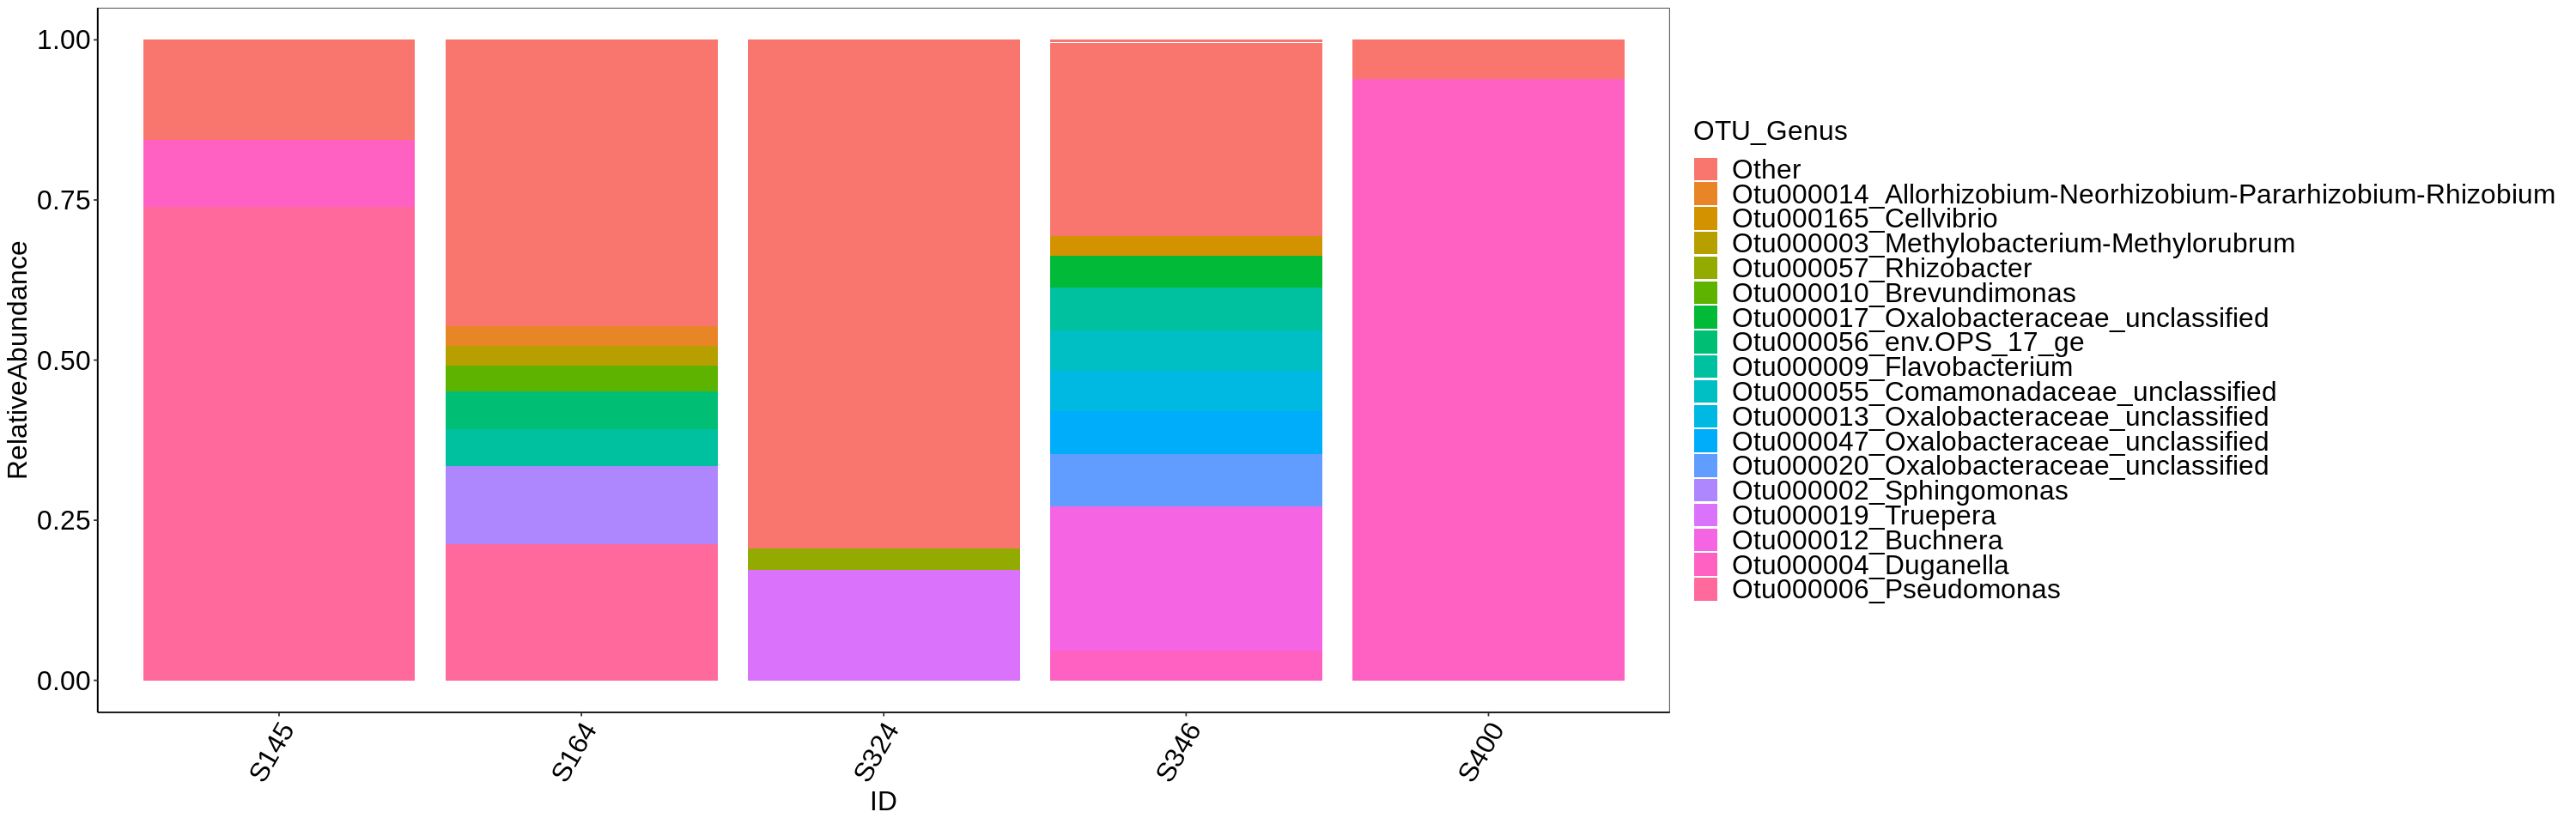

In [30]:
p3 <- ggplot()  + geom_bar(data=tab_taxa1, aes(x=ID, y=RelativeAbundance, fill = OTU_Genus), stat="identity") + scale_color_brewer(palette="Dark2")+
theme_bw() + theme(text = element_text(size = 19 , colour = "black"),
                       axis.text = element_text(size = 19 , colour = "black" ),
                       axis.title = element_text(size = 19 , colour = "black" ),
                       strip.text = element_text(size = 19 , colour = "black" ),
                       axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 19),
                       panel.grid.major = element_blank(),
                       panel.grid.minor = element_blank(),
                       axis.line = element_line(colour = "black") ,
                       legend.title = element_text(color = "black", size = 19),
                       legend.text = element_text(color = "black", size = 19) ,
                       strip.background = element_rect(colour = "black", fill = "white"))

htmlwidgets::saveWidget(ggplotly(p3), "plots/RelativeAbundanceOTU.html")

options(repr.plot.width=25, repr.plot.height=8)
p3

##>Next, we want to compare the composition of the microbiome on the "Genus" level over years across different compartments (Endo- or Epiphytes) of the plant.

Standardize the data frame, melt it and add the taxonomic information :

In [31]:
ra_tab <- decostand(data[-c(1)], method = "total", MARGIN = 1)
ra_tab$ID <- rownames(ra_tab)
melt_tab <- melt(ra_tab)
colnames(melt_tab) = c("ID", "OTU", "RelativeAbundance")
tab_taxa <- merge(x =melt_tab , y = taxonomy , by.x  = "OTU" , by.y = "OTU")
head(tab_taxa)

Using ID as id variables



,OTU,ID,RelativeAbundance,Size,Taxonomy,Kingdom,Phylum,Class,Order,Family,Genus
,<fct>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Otu000002,S324,0.015540194,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
2,Otu000002,S164,0.121678669,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
3,Otu000002,S400,0.005999359,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
4,Otu000002,S346,0.007792384,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
5,Otu000002,S145,0.001571339,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
6,Otu000002,S568,0.095036883,859665,Bacteria;Proteobacteria;Alphaproteobacteria;Sphingomonadales;Sphingomonadaceae;Sphingomonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas


Now, we make the sum of the relative abundance of different orders in all sample colnames.

In [32]:
agg_tab <- aggregate(tab_taxa[,3], list(tab_taxa$Genus), sum)
colnames(agg_tab) <- c("Genus","SumAbundance")
head(agg_tab)

,Genus,SumAbundance
,<chr>,<dbl>
1,01D2Z36_ge,0.07255804
2,0319-6G20_ge,0.81934704
3,1174-901-12,0.17846697
4,37-13_ge,0.01678620
5,67-14_ge,5.35992311
6,A0839_ge,0.05972742


Next, we make a copy/backup of the "Genus" column because we want to change the order of this column to "Other" categories depending on the sum of the relative abundance.

In [33]:
agg_tab$Genus1 <- agg_tab$Genus
agg_tab$Genus1[agg_tab$SumAbundance <=20] <- "Other"
head(agg_tab)

,Genus,SumAbundance,Genus1
,<chr>,<dbl>,<chr>
1,01D2Z36_ge,0.07255804,Other
2,0319-6G20_ge,0.81934704,Other
3,1174-901-12,0.17846697,Other
4,37-13_ge,0.01678620,Other
5,67-14_ge,5.35992311,Other
6,A0839_ge,0.05972742,Other


Lastly, we add the informtion of the changing order names to the main data frame.

In [34]:
tab_taxa1 <- merge(tab_taxa, agg_tab ,by ="Genus")
tab_taxa1$Genus1 <- reorder(tab_taxa1$Genus1 , tab_taxa1$SumAbundance)
tab_taxa1 <- merge(x =tab_taxa1  , y = metadata, by = "ID")
tab_taxa1$Year = as.factor(tab_taxa1$Year)
head(tab_taxa1)

,ID,Genus,OTU,RelativeAbundance,Size,Taxonomy,Kingdom,Phylum,Class,Order,Family,SumAbundance,Genus1,Compartment,Year,Season,Infection_Stage
,<chr>,<chr>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<fct>,<chr>,<chr>
1,S1,Arenimonas,Otu001124,0.0000000000,720,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas;,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,1.39932685,Other,Epi,2014,Spring,Healthy
2,S1,Devosia,Otu000065,0.0008234623,22202,Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Devosiaceae;Devosia;,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Devosiaceae,5.14527618,Other,Epi,2014,Spring,Healthy
3,S1,Acidothermus,Otu001110,0.0000000000,731,Bacteria;Actinobacteriota;Actinobacteria;Frankiales;Acidothermaceae;Acidothermus;,Bacteria,Actinobacteriota,Actinobacteria,Frankiales,Acidothermaceae,0.06264021,Other,Epi,2014,Spring,Healthy
4,S1,Pedosphaeraceae_ge,Otu001532,0.0000000000,487,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Pedosphaerales;Pedosphaeraceae;Pedosphaeraceae_ge;,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Pedosphaerales,Pedosphaeraceae,0.25798231,Other,Epi,2014,Spring,Healthy
5,S1,Haliangium,Otu001214,0.0000000000,658,Bacteria;Myxococcota;Polyangia;Haliangiales;Haliangiaceae;Haliangium;,Bacteria,Myxococcota,Polyangia,Haliangiales,Haliangiaceae,1.29145158,Other,Epi,2014,Spring,Healthy
6,S1,Actinobacteria_unclassified,Otu000442,0.0000000000,2463,Bacteria;Actinobacteriota;Actinobacteria;Actinobacteria_unclassified;Actinobacteria_unclassified;Actinobacteria_unclassified;,Bacteria,Actinobacteriota,Actinobacteria,Actinobacteria_unclassified,Actinobacteria_unclassified,1.44430242,Other,Epi,2014,Spring,Healthy


Plot the Relative Abundance for each compartment over the years for each genus.

In [35]:
#1. Set the colors for each Genus
col <- c("#0F85B0","#FD861E","#F9DA73" , "#16B7B2" , "#AF65B2","#905E45","#416B4C","#CE5A17","#776804","#2B2B83","#999999")
#We know that we need at least 7 colors because we can check the length of the unique charachters in tab_taxa1
length(unique(tab_taxa1$Genus1))

[1] 7

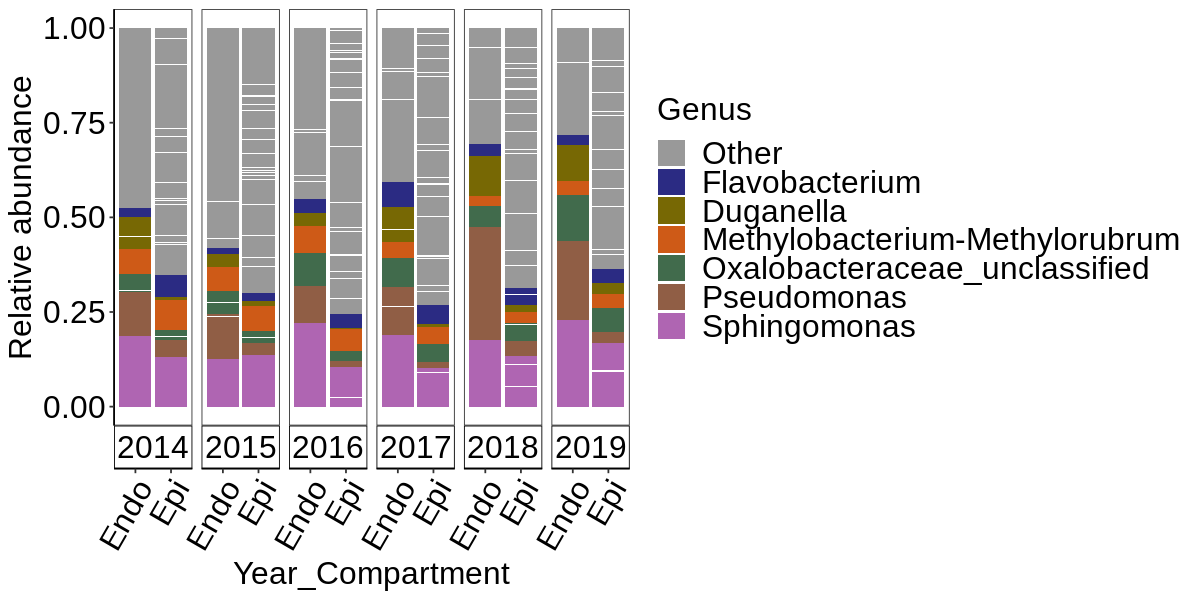

In [36]:
#2. The plot itself is again a bar plot utilizing "tab_taxa1" and the colors we definded above
p4 <- ggplot()  + geom_bar(data=tab_taxa1, aes(x=Compartment, y=RelativeAbundance, fill = Genus1), stat="identity", position="fill") +
    facet_wrap(.~ Year, scales = 'free_x' , nrow = 1 , strip.position="bottom")  + #"facet_wrap()" creates individual plots for the column received (here "Year") so we can use this to make one plot consisting of many subplots by splitting according to "Year"
    scale_fill_manual(values=rev(col)) +
    guides(fill=guide_legend(ncol=1))  +
    theme_bw() + theme(text = element_text(size = 19 , colour = "black"),
                       axis.text = element_text(size = 19 , colour = "black" ),
                       axis.title = element_text(size = 19 , colour = "black" ),
                       strip.text = element_text(size = 19 , colour = "black" ),
                       axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 19),
                       panel.grid.major = element_blank(),
                       panel.grid.minor = element_blank(),
                       axis.line = element_line(colour = "black") ,
                       legend.title = element_text(color = "black", size = 19),
                       legend.text = element_text(color = "black", size = 19) ,
                       strip.background = element_rect(colour = "black", fill = "white")) +
         ylab("Relative abundance") + xlab("Year_Compartment") + labs(fill = "Genus")

#htmlwidgets::saveWidget(ggplotly(p4), "plots/Genus_RA_Plot.html") -> File too large to save

options(repr.plot.width=10, repr.plot.height=5)

p4

Can we see any differences between Endophytic and Epiphytic samples regarding the Genus? If so, do you think this difference is significant?

<img src="https://github.com/IshtarMM/HandsOnMicrobiome/blob/main
/scripts/pictures/statistic.png?raw=true" height=800 />


---
###To quantify the difference bewteen both sample types we can use a Wilcoxon signed-rank test because we have only 2 samples (Endo- and Epiphytes).

In [38]:
wilcox.test(RelativeAbundance ~ Compartment, data = tab_taxa1)


	Wilcoxon rank sum test with continuity correction

data:  RelativeAbundance by Compartment
W = 1.6156e+11, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


We can see here that the p-value is <= 0.05, which means we can accept our hypothesis that there is a significant difference between the two compartments.

Now we want to compare the genus among years. We have more than 2 groups (multiple genus), so we need to employ an Anova and Tukey HSD test.

In [39]:
anova <- aov(RelativeAbundance ~ Genus1, data = tab_taxa1)
summary(anova)
TukeyHSD(aov(RelativeAbundance ~ Genus1, data = tab_taxa1))

                 Df Sum Sq Mean Sq F value Pr(>F)    
Genus1            6   2.05  0.3409    5287 <2e-16 ***
Residuals   1327394  85.59  0.0001                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = RelativeAbundance ~ Genus1, data = tab_taxa1)

$Genus1
                                                                      diff
Flavobacterium-Other                                          0.0005269018
Duganella-Other                                               0.0419432042
Methylobacterium-Methylorubrum-Other                          0.0049424727
Oxalobacteraceae_unclassified-Other                           0.0011237081
Pseudomonas-Other                                             0.0072766695
Sphingomonas-Other                                            0.0022462025
Duganella-Flavobacterium                                      0.0414163023
Methylobacterium-Methylorubrum-Flavobacterium                 0.0044155708
Oxalobacteraceae_unclassified-Flavobacterium                  0.0005968063
Pseudomonas-Flavobacterium                                    0.0067497676
Sphingomonas-Flavobacteri

##<font color="red">**Question 4:**</font>

Plot and compare the composition of the microbiome on "Family" level between infected and non-infected samples.

Is there any significant difference?

In [ ]:
#Type your answer here

In [ ]:
#Type your answer here

In [ ]:
#Type your answer here


#>Next, we will look at the diversity of the samples.

First we calculate the within sample diversity (alpha-diversity) and plot it.

In [41]:
alpha_div <- data.frame(diversity(data[-c(1)], index ="shannon"))       #Create a new data frame where use all but the first column in "data" to calculate the alpha-diversity with the Shannon Index
colnames(alpha_div) = "ShannonDiversity"                                #Change column name
alpha_div <- merge(alpha_div, metadata, by = "row.names")               #Merge "alpha_div" and "metadata"
head(alpha_div)

,Row.names,ShannonDiversity,ID,Compartment,Year,Season,Infection_Stage
,<I<chr>>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>
1,S1,4.756246,S1,Epi,2014,Spring,Healthy
2,S10,5.733597,S10,Epi,2014,Fall,Infected
3,S100,1.969159,S100,Endo,2014,Fall,Healthy
4,S101,3.475837,S101,Endo,2014,Fall,Healthy
5,S102,1.822367,S102,Endo,2014,Fall,Healthy
6,S103,3.814751,S103,Endo,2015,Spring,Healthy


Install the "ggpubr" package, which is gives some more tools to create plots for publications.

In [ ]:
#install.packages("ggpubr")
#library(ggpubr)

#Because installation takes a long time we will not use ggpubr. It can be used to statistically compare groups directly in a plot.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



##To visualize the alpha diversity between the compartments we create a ggplot and statistically compare them using a wilcoxon test.

Warning message:
“The dot-dot notation (`..lower..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(lower)` instead.”


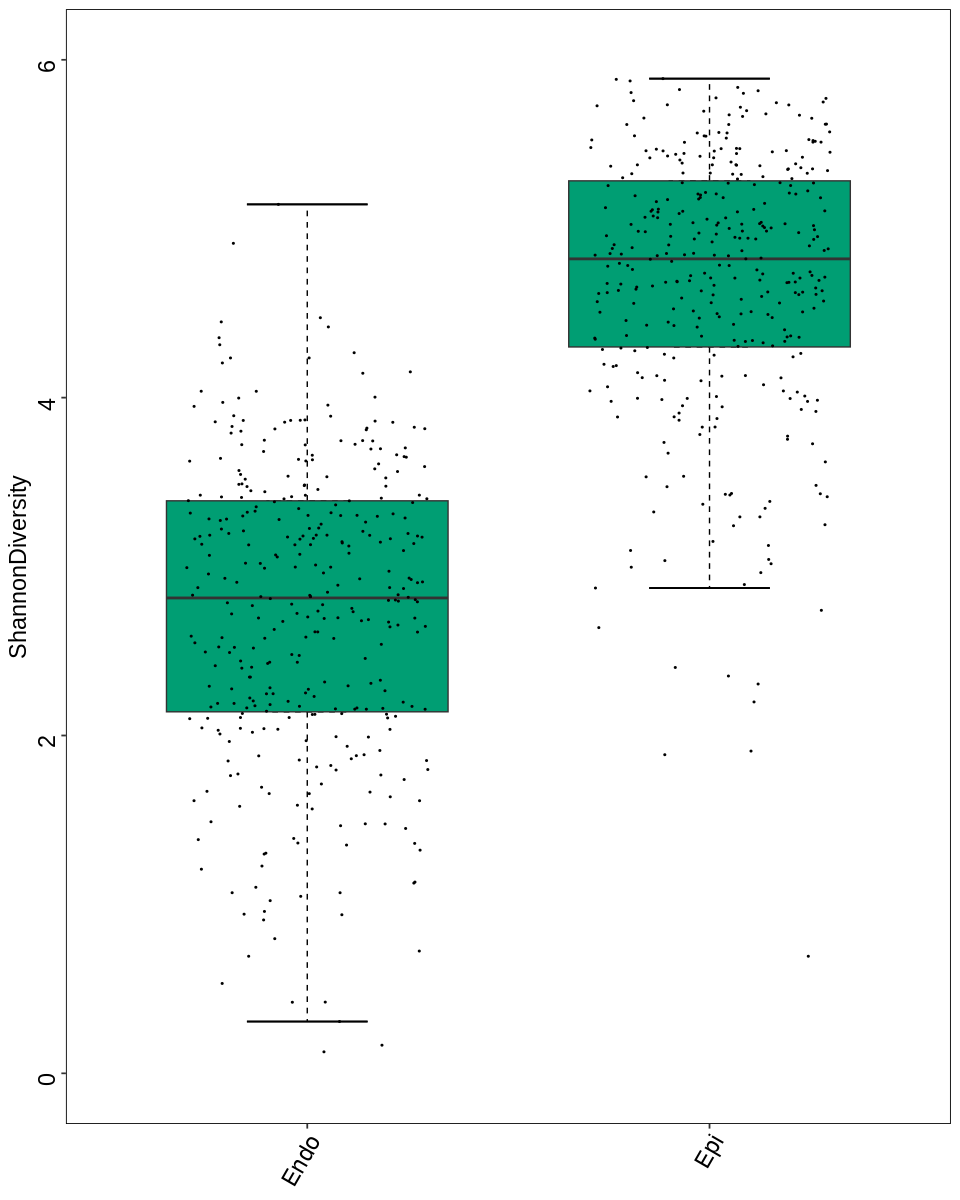

In [42]:
plot_alpha_diversity <- ggplot(alpha_div, aes(x=Compartment, y=ShannonDiversity)) + geom_boxplot(fill="#009E73", color="black", outlier.shape=NA, width=0.2, lwd=0.4, linetype="dashed", position=position_dodge(width=6)) +
    stat_boxplot(aes(ymin = ..lower.., ymax = ..upper..) ,fill='#009E73' ,outlier.shape=NA ,width=0.7 , lwd = 0.4) +
    stat_boxplot(geom = "errorbar", aes(ymin = ..ymax..), width=0.3) +
    stat_boxplot(geom = "errorbar", aes(ymax = ..ymin..) ,width=0.3) +
    geom_jitter(alpha = 1 , color = "black" , position = position_jitter(width = 0.3) , size = 0.2) +
    theme(axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 14),
          axis.text.y = element_text(angle=90, hjust=1 , size = 14 , colour="black" ) ,
          axis.title.y =  element_text(angle=90, size = 14) ,
          axis.title.x = element_blank() ,
          text = element_text(size = 40),
          panel.background = element_rect(colour = "black" , fill = "NA"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + ylim(0,6) #+
    #stat_compare_means(aes(label=paste0("p = ", ..p.signif..)), method="wilcox.test")

options(repr.plot.width=8, repr.plot.height=10)
plot_alpha_diversity

###To confirm the statistical difference we can "observe" we need to conduct a significance test.

In [43]:
wilcox.test(ShannonDiversity ~ Compartment, data = alpha_div)


	Wilcoxon rank sum test with continuity correction

data:  ShannonDiversity by Compartment
W = 6463.5, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


###Most used alpha-diversity indices are:

- **Simpson index:** Is a dominance index because it gives more weight to common or dominant species. In this case, a few rare species with only a few representatives will not affect the diversity.
- **Shannon index:** Is an information statistic index, which means it assumes all species are represented in a sample and that they are randomly sampled.
- **Chao index:** Is calculated like normal species richness but takes into account the size of the sample and the probability to miss some species (applies a correction for this).

##<font color='red'>Q5:</font>
##Calculate within sample diversity (alpha diversity) between infected and non-infected samples.

##Is there a significant difference?

In [ ]:
#type your. answer here:

##>Calculate the between sample diversity (beta diversity) and plot it.

While alpha diversity represents the diversity within an ecosystem or a sample, beta-diversity represents the difference between two ecosystems/samples. In other words, how similar or different are two ecosystems or samples? So, beta diversity is a distance between two samples. Microbial ecologists do not use Euclidean distances but usually use Bray-Curtis, Jaccard or weight/unweight Unifrac distances to estimate the betadiversity.

- Bray-Curtis dissimilarity: based on occurrence data (abundance)
- Jaccard distance: based on presence/absence data (does not include abundance information).
- UniFrac distances: take into account the occurrence table and the phylogeny diversity (sequence distance). Weighted or unweighted UniFrac distances depending if taking into account relative abundance or only presence/absence.

In [44]:
install.packages("ade4")
library(ade4)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘pixmap’, ‘sp’, ‘RcppArmadillo’




To investigate the beta diversity we have to calculate the dissimilarities between the sample, perform a principal coordinate analysis (PCoA) and plot the data using a scatterplot.

Warning message in dudi.pco(vegdist(data[-c(1)], method = "bray", binary = FALSE), :
“Non euclidean distance”


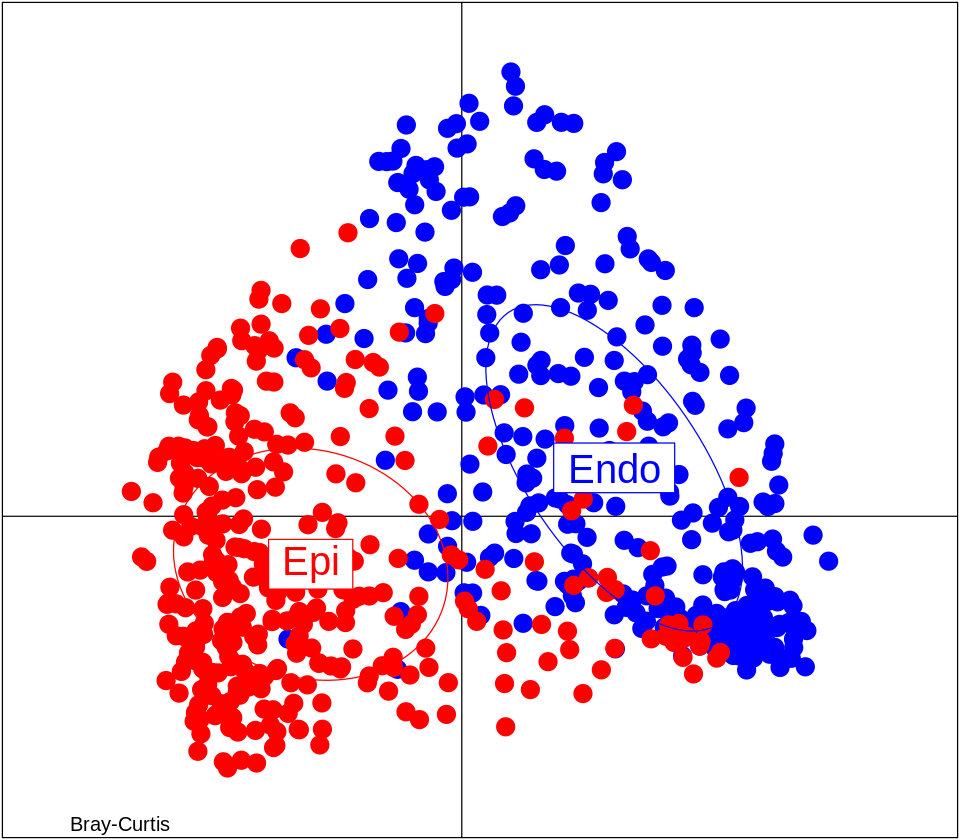

In [45]:
pca_bray_rarefied.tab <- dudi.pco(vegdist(data[-c(1)], method = "bray", binary=FALSE), scannf=F)  #Calculates the Bray-Curtis dissimilarity between samples
metadata$Compartment <- as.factor(metadata$Compartment)   #Declarese that the column "Compartment" is seen as a factor and not a string
options(repr.plot.width=8, repr.plot.height=7)            #Sets plot size options
s.class(pca_bray_rarefied.tab$li, metadata$Compartment, xax=1, yax=2, cpoint=3, grid=F, addaxes=T, cellipse=1, cstar=0, axesell=0, col = c("blue","red"), clabel = 2, sub="Bray-Curtis") #Plots the Bray-Curtis dissimilarities we just calculated using a scatterplot

To test whether the groups are different with respect to centroid and dispersion, a PERMANOVA statistical test is performed. For this a multivariate extension of ANOVA will be used, as there are many OTUs that will be used in the test. The extension is based on distances between samples. The test compares distances of samples within the same group to distances of samples from different groups. If the distance between samples from the different groups is much larger than samples from the same group, we conclude that the groups are not equal.

In order to test the significance of the result, a permutation test is used. Thus all samples are randomly mixed over the groups and the test is repeated many times. If the ratio (between group distance / within group distance) is much larger for the original data than for the permutations, we conclude there is a statistical significant difference.

The test can be applied in combination with any distance measure.

In [46]:
#Permanova test using the vegan package
ado <- adonis2(data[-c(1)]~metadata$Compartment, permutations=99, method="bray")
ado

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
metadata$Compartment,1,22.80581,0.08781352,67.09815,0.01
Residual,697,236.90145,0.91218648,NA,NA
Total,698,259.70726,1.00000000,NA,NA


##<font color='red'>Q6:</font>
##Calculate between sample diversity (beta diversity) between infected and non-infected samples among epi- and endophyte samples.

##How much variation of data are explained by infection in the plants?

In [ ]:
#Type your answer here

##>Now we will calculate the correlation between the OTUs.

Here you can find more information on network analysis:

https://psbweb05.psb.ugent.be/conet/microbialnetworks/spieceasi.php

In [47]:
#Create a new data frame from our original "data" without the first column
data_net <- data.frame(t(data[-c(1)]))
#Displays the dimensions (number of rows and columns) of "data_net"
dim(data_net)
#Renames the column
data_net$OTU <- rownames(data_net)
#Merges OTU and Genus column from taxonomy with data_net by OTU
data_net <- merge(taxonomy[c("OTU" ,"Genus")] , data_net , by = "OTU")
#Creates a new colum which combines the OTU and Genus column separated by "_"
data_net$OTU_Genus <- paste(data_net$OTU , data_net$Genus , sep = "_")
#Sets the rownames of data_net to the values from OTU_Genus
rownames(data_net) <- data_net$OTU_Genus
#Removes the columns "OTU", "Genus", and "OTU_Genus" from the data frame
data_net <- subset(data_net , select = -c(OTU , Genus , OTU_Genus))
#Select only the rows where the sums of the values is >= 2000
data_net <- data_net[rowSums(data_net)>=2000 , ]
#Displays dimensions again
dim(data_net)
head(data_net)

[1] 1899  699

[1] 480 699

,S324,S164,S400,S346,S145,S568,S389,S459,S566,S579,⋯,S452,S605,S621,S612,S590,S664,S422,S613,S430,S616
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Otu000002_Sphingomonas,879,4410,206,230,45,2654,18878,714,458,1038,⋯,29,7,6,6,0,11,3,1,0,0
Otu000003_Methylobacterium-Methylorubrum,1632,1123,4,179,148,136,968,2418,3,38,⋯,34,10,2,2,1,4,20,0,2,0
Otu000004_Duganella,22,82,32232,1363,2960,8759,1091,77,8,2664,⋯,4,5,0,10,0,11,0,0,0,0
Otu000005_Pseudomonas,5,1087,0,259,134,214,1157,291,3,14513,⋯,2,9,2,11,2,4,2,13,0,0
Otu000006_Pseudomonas,20,7691,184,1,21187,415,260,528,23813,1457,⋯,0,0,0,5,0,0,0,0,0,0
Otu000009_Flavobacterium,678,2096,145,1969,0,5556,378,117,6,134,⋯,4,11,2,18,1,22,0,7,2,0


The issue with correlations between microbes in microbiome data is that the data is compositional, which means it describes the relative abundance of microbes and not absolute numbers like if we determine the microbial load using qPCR. Each OTU contributes a proportion of reads that add up to 100% in each sample. The problem with searching for correlations here is that if there is an increase in one OTU all of the other OTUs must decrease. This ends up looking like a negative correlation between the increased OTU and everything else when this might not be the case.

SparCC determines correlations between OTUs taking this specific problem into account.

In [ ]:
remotes::install_github("zdk123/SpiecEasi") #takes few minutes
library(SpiecEasi)

In [91]:
#Calculate the correlation matrix
sparcc.data <- sparcc(t(data_net))

In [ ]:
library(igraph)

In [92]:
head(sparcc.data$Cor)

1.00000000,0.42510092,0.15051171,0.2085013,0.24271094,0.09384303,0.31631956,0.36207105,-0.03170988,0.08481359,⋯,-0.075625749,-0.11142335,-0.08167997,-0.03602026,-0.09434438,-0.0072952266,-0.094176785,-0.05286215,-0.03438147,-0.06308371
0.42510092,1.00000000,0.07877422,0.1052907,0.04921654,0.19221311,0.37793490,0.34660793,-0.07424594,0.14769094,⋯,-0.121492540,-0.14773860,-0.11033293,-0.16280373,-0.04772378,-0.0678472438,-0.153315870,-0.09565940,-0.13552666,-0.15931980
0.15051171,0.07877422,1.00000000,0.3310947,0.39238643,0.22109714,0.14627536,0.07649675,0.08450012,0.20782986,⋯,0.007110244,0.02696242,-0.05402235,0.06312180,0.02101906,-0.0709578940,0.029178453,0.07148634,0.03729733,-0.02106871
0.20850134,0.10529073,0.33109467,1.0000000,0.25816445,0.27276093,0.22885094,0.16808547,0.09172748,0.14930468,⋯,-0.013831293,-0.03484648,-0.07977731,0.06053157,0.03168968,-0.0639379107,0.004129021,0.02539540,-0.03604798,-0.08591827
0.24271094,0.04921654,0.39238643,0.2581645,1.00000000,0.11437782,0.03424479,0.05804175,0.14274322,-0.03460578,⋯,0.049465814,0.06567310,-0.06808564,0.14305651,0.06774718,0.0050377796,0.074467098,0.11773971,0.09816079,-0.07479064
0.09384303,0.19221311,0.22109714,0.2727609,0.11437782,1.00000000,0.35175205,0.24819617,-0.11371239,0.39352431,⋯,-0.091261377,-0.07450215,-0.09320541,-0.10663081,0.01952751,-0.0004231164,-0.103213072,-0.10187326,-0.14452081,-0.09068161


##>Next, we define an (arbitrary) threshold for SparCC the correlation matrix for the graph.

In [93]:
colnames(sparcc.data$Cor) <- rownames(data_net)
rownames(sparcc.data$Cor) <- colnames(sparcc.data$Cor)
#Creates the threshold
sparcc.graph <- abs(sparcc.data$Cor) >= 0.3
#Sets diagonal elements to 0. This typically removes self-loops in a correlation network (Diagonal = Correlation with itself)
diag(sparcc.graph) <- 0
#Remove the ones with less than 4 connections
sparcc.graph = sparcc.graph[rowSums(sparcc.graph)>=4,]
sparcc.graph = sparcc.graph[,(colnames(sparcc.graph) %in% rownames(sparcc.graph))]

library(Matrix)
#Converts "sparcc.graph" matrix to a sparce matrix. Sparse matrices are used to efficiently store and manipulate large matrices with mostly zero values.
sparcc.graph <- Matrix(sparcc.graph, sparse=TRUE)
## Create igraph objects
ig.sparcc <- adj2igraph(sparcc.graph,vertex.attr = list(name = rownames(sparcc.graph), ff = 1:nrow(sparcc.graph)))
dim(sparcc.graph)

[1] 140 140

In [94]:
#save the network correlation file for further visulization using 'Cytoscape' program.
Cors1 <- as.matrix(sparcc.data$Cor)
Cors1[upper.tri(Cors1, diag=TRUE)]<-NA
Cors2 <- as.data.frame(as.table(Cors1))
colnames(Cors2)<-c("Node1","Node2","Cor")
#remove NA lines
Edge_table_final <- Cors2[!is.na(Cors2$Cor),]
#select correlations with abs value higher than 0.2
Edge_table_final <- subset(Edge_table_final,abs(Edge_table_final$Cor)>=0.2)
Edge_table_final$CorType <- ifelse(Edge_table_final$Cor >=0, "Positive", "Negative")
head(Edge_table_final)
write.table(Edge_table_final , 'correlationTable.csv' , row.names= FALSE , quote = FALSE , sep = ',')

,Node1,Node2,Cor,CorType
,<fct>,<fct>,<dbl>,<chr>
2,Otu000003_Methylobacterium-Methylorubrum,Otu000002_Sphingomonas,0.4251009,Positive
4,Otu000005_Pseudomonas,Otu000002_Sphingomonas,0.2085013,Positive
5,Otu000006_Pseudomonas,Otu000002_Sphingomonas,0.2427109,Positive
7,Otu000010_Brevundimonas,Otu000002_Sphingomonas,0.3163196,Positive
8,Otu000011_Rathayibacter,Otu000002_Sphingomonas,0.3620711,Positive
12,Otu000015_Sphingomonas,Otu000002_Sphingomonas,0.2895618,Positive


##>Next, we will visualize the correlation matrix as a network.

Network graph (forced directed graph) is a mathematical structure (graph) for visually presenting networks of connected entities as links and nodes. Nodes or vertices represent data points and links represent the connection between them. Links are often called edges in social or microbial networks.

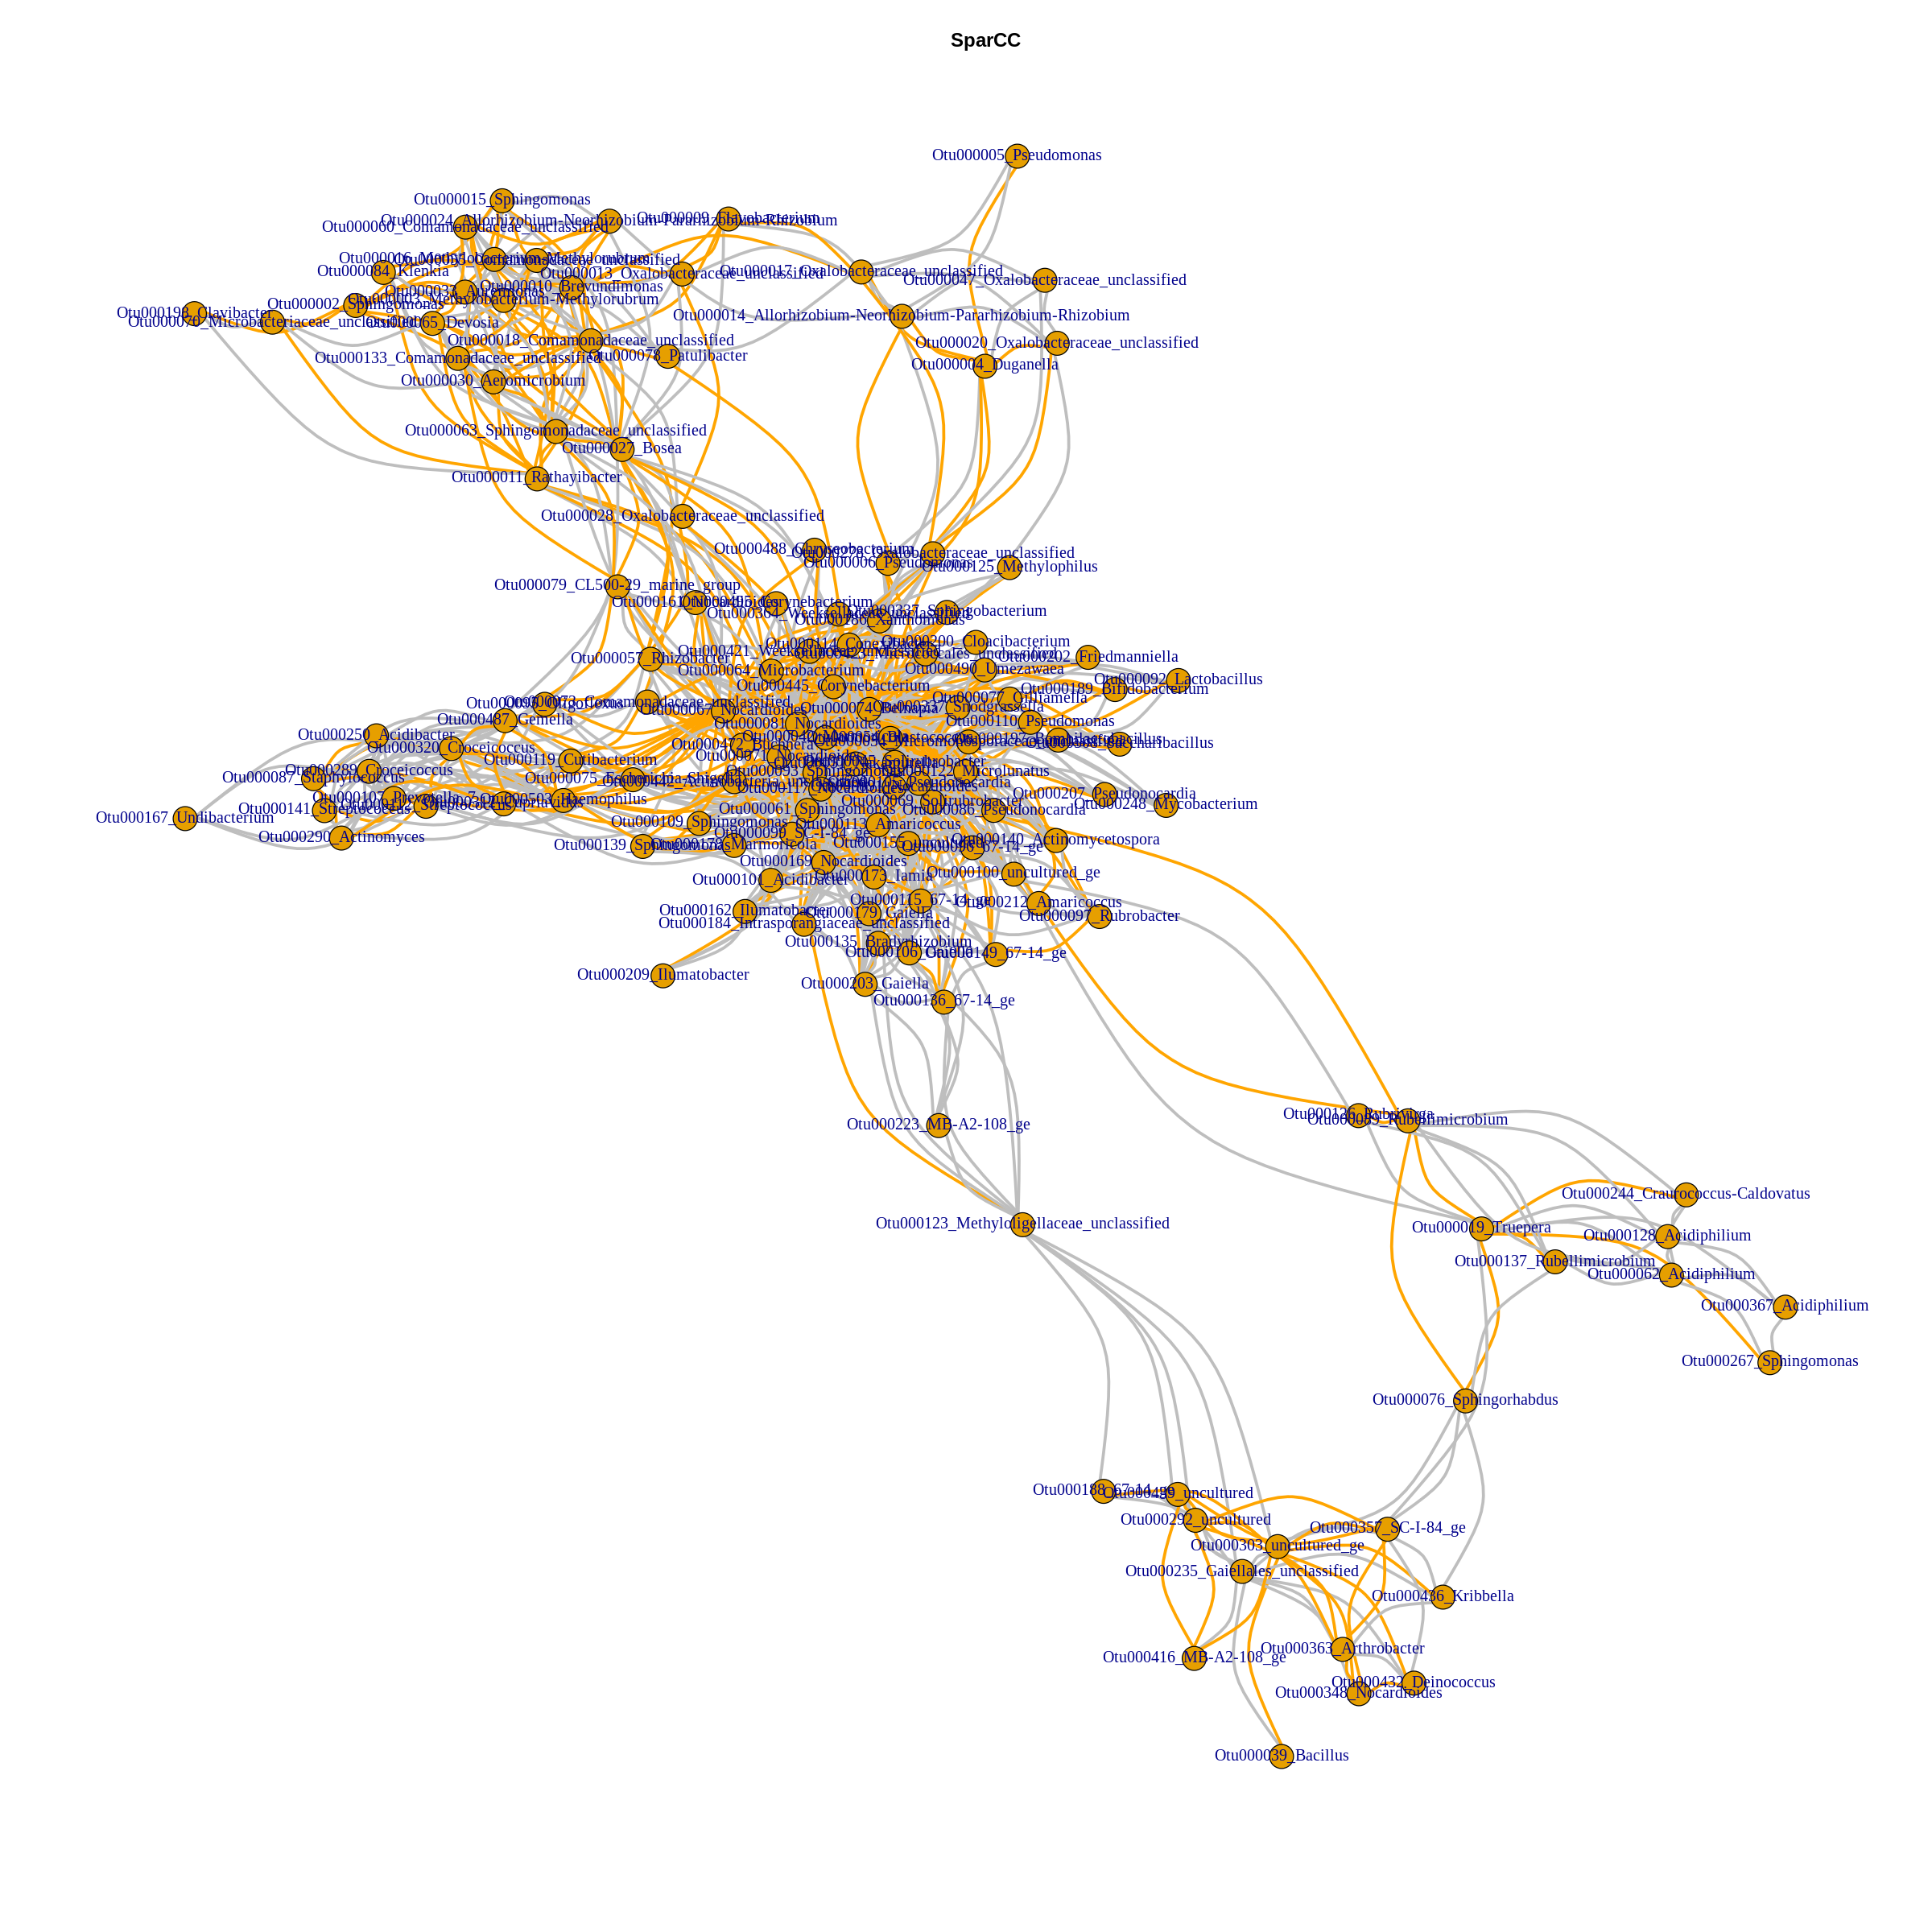

In [95]:
options(repr.plot.width=20, repr.plot.height=20)
cor_values <- sparcc.data$Cor[which(E(ig.sparcc) != 0)]
edge_colors <- ifelse(cor_values >= 0, "orange", "gray")
plot(ig.sparcc, vertex.label = colnames(sparcc.graph), main = "SparCC", vertex.size = 3, edge.color = edge_colors, edge.width = 3, edge.curved=0.5)

Do some analysis on the network (calculate centrality and degree of each node).

Centrality measures address the question:
**'Who is the most important or central node in this network?'**

Centrality measures are a vital tool for understanding networks.

These algorithms use graph theory to calculate the importance of any given node in a network. They cut through noisy data, revealing parts of the network that need attention – but they all work differently. Each measure has its own definition of ‘importance’, so you need to understand how they work to find the best one for your graph visualization applications.

- **Degree or Degree Centality**: Assigns an importance score based simply on the number of links held by each node.

What it tells us: How many direct connections each node has to other nodes in the network.
When to use it: For finding very connected microbes, microbes that are likely to provide something important or microbes that can quickly connect with the wider network.
- **Betweenness centrality**: Measures the number of times a node lies on the shortest path between other nodes.

What it tells us: This measure shows which nodes are ‘bridges’ between nodes in a network. It does this by identifying all the shortest paths and then counting how many times each node falls on one.
When to use it: For finding the microbes that influence the flow around a system.
- **Closeness centrality**: Scores each node based on their ‘closeness’ to all other nodes in the network.

What it tells us: This measure calculates the shortest paths between all nodes, then assigns each node a score based on its sum of shortest paths. When to use it: For finding the microbes that are best placed to influence the entire network most quickly.

- **EigenCentrality**: Like degree, EigenCentrality measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network.

What it tells us: By calculating the extended connections of a node, EigenCentrality can identify nodes with influence over the whole network, not just those directly connected to it. When to use it: EigenCentrality is a good ‘all-round’ score, handy for understanding microbial networks.


In [96]:
library(igraph)
#Calculate the closeness centrality for each node in "ig.sparcc". The results are stored in "closeness"
closeness <- data.frame(closeness(ig.sparcc, mode="all", weights=NA))
#Calculate the betweenness centrality for each node in "ig.sparcc". The results are stored in "betweenness"
betweenness <- data.frame(betweenness(ig.sparcc, directed=F, normalized=TRUE))
#Calculate the degree for each node in "ig.sparcc". The results are stored in "degree"
degree <- data.frame(degree(ig.sparcc), mode="all")
#Combine all 3 data frames into a single one
net_analysis <- cbind(closeness, betweenness[1], degree)
colnames(net_analysis) <- c("ClosenessCentrality", "BetweennessCentrality", "Degree")

taxonomy$OTU_Genus <- paste(taxonomy$OTU, taxonomy$Genus, sep="_")
#Merge "net_analysis" and "taxonomy" based on "row.names" and "OTU_Genus"
net_analysis <- merge(net_analysis, taxonomy, by.x="row.names", by.y="OTU_Genus")
colnames(net_analysis)[1] <- "OTU_Genus"
#Remove all rows with missing values (NA)
net_analysis <- na.omit(net_analysis)
#Remove rows where Closeness Centrality is 1 and Betweenness Centrality is 0
net_analysis <- net_analysis[!(net_analysis$ClosenessCentrality==1 & net_analysis$BetweennessCentrality==0), ]

##Plot the degree distribution of the network.

In the study of graphs and networks, the degree of a node in a network is the number of connections it has to other nodes and the degree distribution is the probability distribution of these degrees over the whole network.

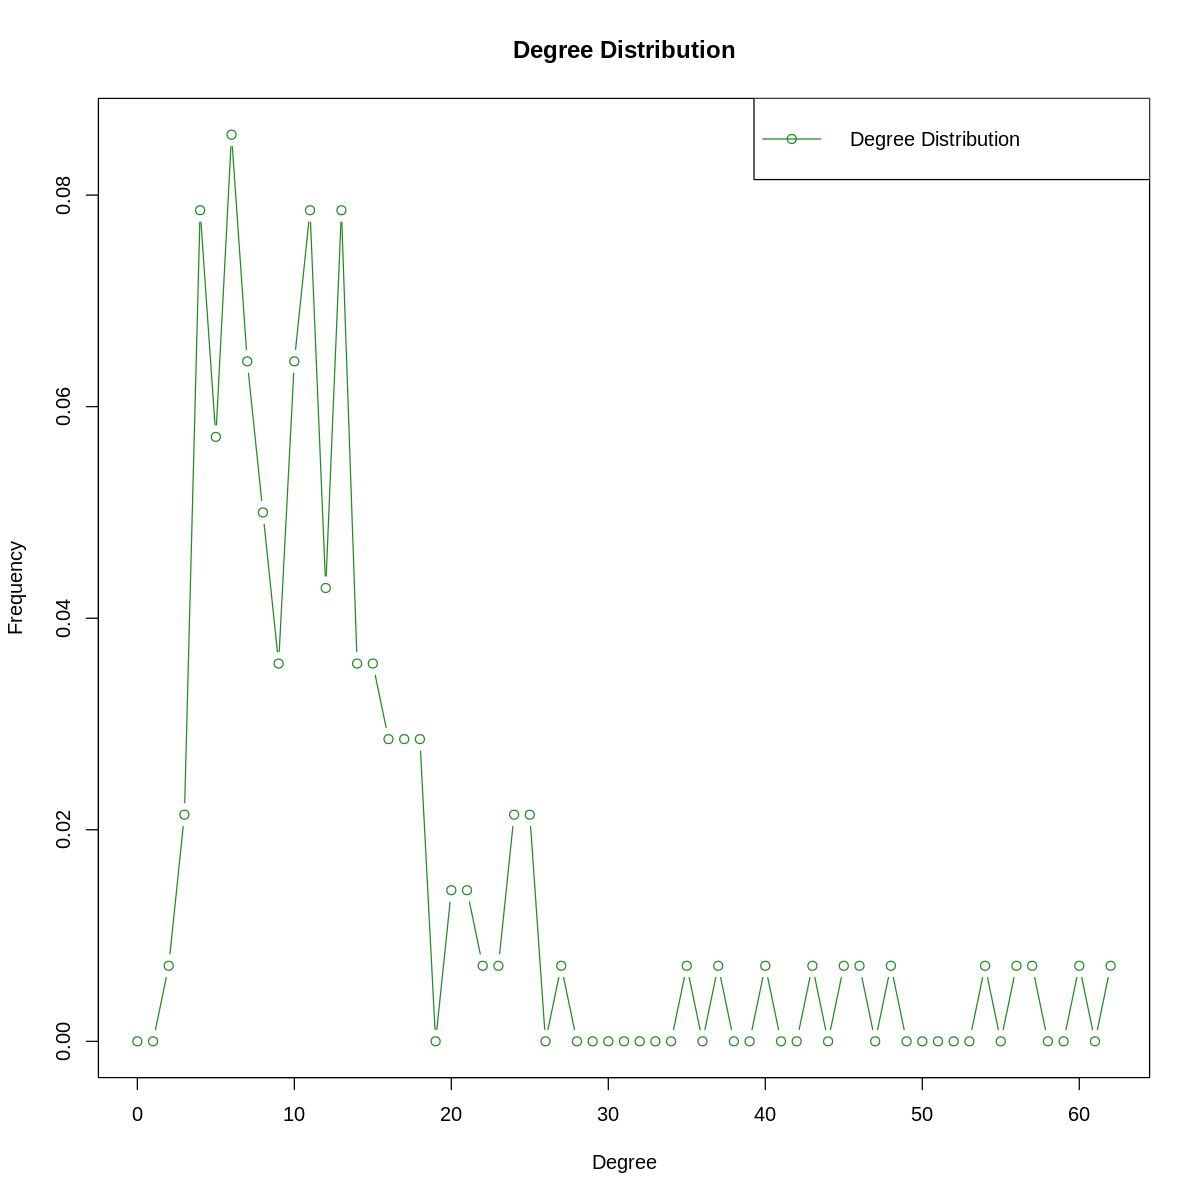

In [97]:
options(repr.plot.width=10, repr.plot.height=10)
#Calculate the degree distribution in "ig.sparcc"
dd.sparcc <- degree.distribution(ig.sparcc)
#Plot the distribution
plot(0:(length(dd.sparcc)-1), dd.sparcc, type="b",
      ylab="Frequency", xlab="Degree", main="Degree Distribution", col="forestgreen")
legend("topright", legend="Degree Distribution", col="forestgreen", pch=1, lty=1)

The degree distribution is very important in studying networks. Most networks in the real world are highly right-skewed, meaning that a large majority of nodes have low degree but a small number, known as "**hubs**", have high degree. Most microbial networks were argued to have degree distributions that approximately follow a power law. Such networks are called **scale-free networks**.

Let's find the HUBs in the network and plot them.

In [98]:
install.packages('ggrepel')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [99]:
#Set the threshold for a HUB
n <- 10
library(ggrepel)
#Select the top n% of nodes based on the highest betweenness centrality and store the "OTU_Genus" value in "top5_BC"
top5_BC <- net_analysis[net_analysis$BetweennessCentrality > quantile(net_analysis$BetweennessCentrality, prob=1-n/100),]$OTU_Genus
#Calculate the minimum betweenness centrality value among the top nodes
top5_BC_min <- min(net_analysis[net_analysis$BetweennessCentrality > quantile(net_analysis$BetweennessCentrality, prob=1-n/100),]$BetweennessCentrality)
#Select the top n% of nodes based on the highest closeness centrality and store the "OTU_Genus" value in "top5_CC"
top5_CC <- net_analysis[net_analysis$ClosenessCentrality > quantile(net_analysis$ClosenessCentrality, prob=1-n/100),]$OTU_Genus
#Calculate the minimum closeness centrality value among the top nodes
top5_CC_min <- min(net_analysis[net_analysis$ClosenessCentrality > quantile(net_analysis$ClosenessCentrality, prob=1-n/100),]$ClosenessCentrality)

#Find the intersection of "OTU_Genus" ind "top5_BC" and "top5_CC"
p5_Intersection <- top5_BC[which((top5_BC %in% top5_CC) == TRUE)]

p5_IntersectionH = p5_Intersection
length(p5_IntersectionH)

[1] 9

In [100]:
#Creates a data frame from "p5_IntersectionH" and assigns the value "yes" to the "core" column
core = as.data.frame(p5_IntersectionH)
core$core = "Yes"
colnames(core) = c("Species", "HUB")

#Filters "net_analysis" to exclude the OTU_Genus present in "core"
select = subset(net_analysis, !(OTU_Genus %in% core$Species))
select$core = "No"

#Renames "OTU_Genus" and "core" from "select" and rename them
select1 = select[,c("OTU_Genus", "core")]
colnames(select1) = c("Species", "HUB")

#Merge the original "net_analysis" with "newnet_analysis"
newnet_analysis = rbind(select1, core)
newnet_analysisH = merge(x=net_analysis, y=newnet_analysis, by.x="OTU_Genus", by.y="Species")

newnet_analysisH <- newnet_analysisH[complete.cases(newnet_analysisH),]
newnet_analysisH = newnet_analysisH[newnet_analysisH$Degree > 10, ]
head(newnet_analysisH)

,OTU_Genus,ClosenessCentrality,BetweennessCentrality,Degree,NA,OTU,Size,Taxonomy,Kingdom,Phylum,Class,Order,Family,Genus,HUB
,<I<chr>>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,Otu000003_Methylobacterium-Methylorubrum,0.002369668,0.002533597,14,all,Otu000003,291965,Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Methylobacterium-Methylorubrum;,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Beijerinckiaceae,Methylobacterium-Methylorubrum,No
7,Otu000010_Brevundimonas,0.002421308,0.008101302,18,all,Otu000010,161224,Bacteria;Proteobacteria;Alphaproteobacteria;Caulobacterales;Caulobacteraceae;Brevundimonas;,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Brevundimonas,No
8,Otu000011_Rathayibacter,0.003048780,0.061297135,16,all,Otu000011,142746,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Microbacteriaceae;Rathayibacter;,Bacteria,Actinobacteriota,Actinobacteria,Micrococcales,Microbacteriaceae,Rathayibacter,No
14,Otu000018_Comamonadaceae_unclassified,0.002577320,0.012712406,18,all,Otu000018,67867,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Comamonadaceae;Comamonadaceae_unclassified;,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Comamonadaceae,Comamonadaceae_unclassified,No
15,Otu000019_Truepera,0.002506266,0.067106631,11,all,Otu000019,60310,Bacteria;Deinococcota;Deinococci;Deinococcales;Trueperaceae;Truepera;,Bacteria,Deinococcota,Deinococci,Deinococcales,Trueperaceae,Truepera,No
18,Otu000027_Bosea,0.003039514,0.083797978,24,all,Otu000027,50873,Bacteria;Proteobacteria;Alphaproteobacteria;Rhizobiales;Beijerinckiaceae;Bosea;,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Beijerinckiaceae,Bosea,No


In [101]:
#Initialize "ggplot" with data from "newnet_analysisH" and assign aesthetics and add various layers to the plot
expression <- ggplot(newnet_analysisH, aes(x=ClosenessCentrality, y=BetweennessCentrality, label=Genus))
z <- expression + geom_point(aes(colour=Degree, size = Degree) ,stat= "identity",position="identity",alpha= 0.4 ) +
    scale_colour_gradient(low = "blue", high = "red") +
    labs(title = "Hub analysis") +
    scale_size_area(max_size = 10)+
    geom_vline(xintercept = top5_CC_min, linetype="dashed") +
    geom_hline(yintercept = top5_BC_min, linetype= "dashed") +
    scale_x_continuous("Closeness Centrality") +
    scale_y_continuous("Betweenness Centrality") +
    scale_shape_manual(values=c(21, 19)) +
    geom_text_repel(data=subset(newnet_analysisH, HUB=="Yes"),size = 7,
                    box.padding   = 1.5,
                    point.padding = 0.5,
                    force         = 100,
                    segment.size  = 0.4,
                    segment.color = "darkgreen") +
    theme_bw()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    theme(text = element_text(size=15))


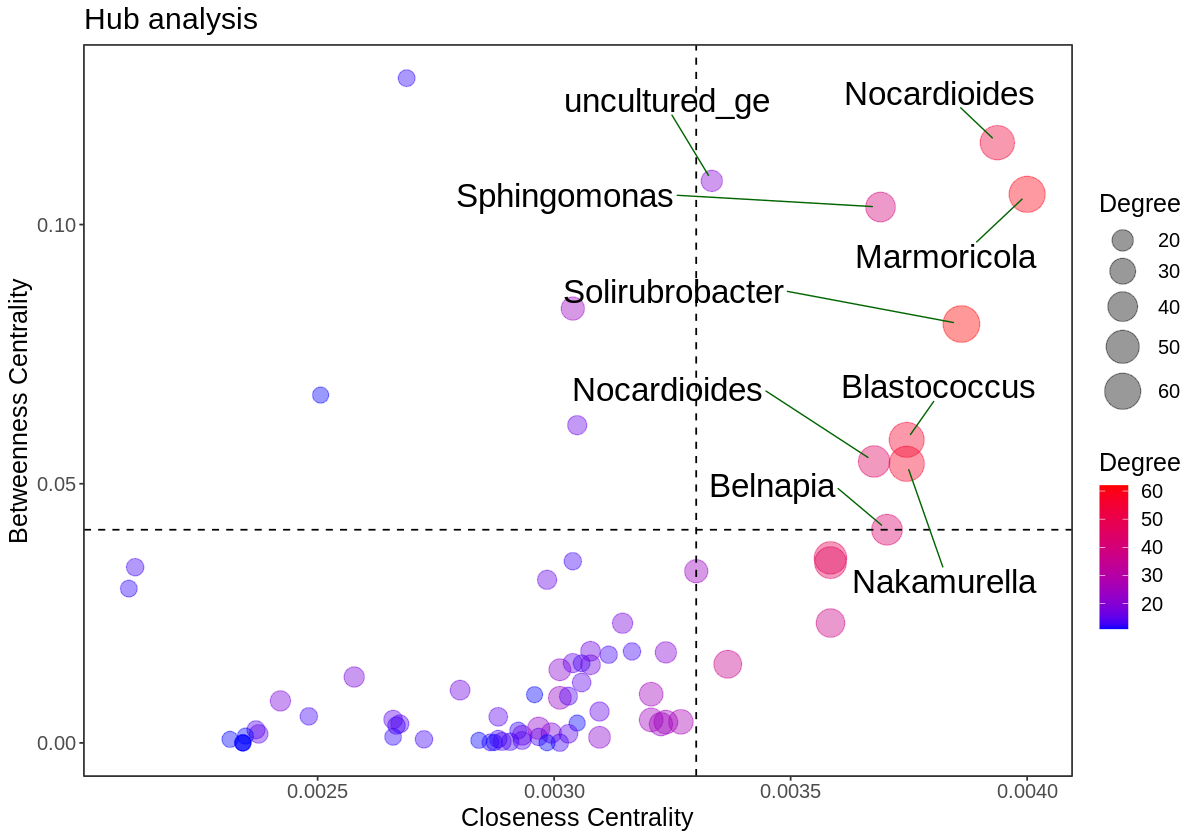

In [102]:
options(repr.plot.width=10, repr.plot.height=7)
z

In [ ]:
head(newnet_analysisH)

write.table(Edge_table_final , 'correlationTable.csv' , row.names= FALSE , quote = FALSE , sep = ',')



##<font color='red'>Q7:</font>
##Calculate network analysis for infected samples

In [ ]:
#Type your answer here

#Hint: first subset the otu table of infected samples
metadata_infected_samples <- subset(metadata , metadata$Infection_Stage=="Infected")
data1 <- data[rownames(data)%in% rownames(metadata_infected_samples), ]
data_net <- data.frame(t(data1[-c(1)]))

**Outlook: Machine learning models**


An approach to identify underlying microbial community patterns for infection and season using machine learning.

<img src="https://github.com/IshtarMM/Practical_Course/blob/master/pic/machinelearning.jpg?raw=true" />


----

**Would you like to practise your R programming from beginning? Check out the following notebook:**

https://colab.research.google.com/github/IshtarMM/HandsOnMicrobiome/blob/main/scripts/Rbasic.ipynb


<img src="https://github.com/IshtarMM/HandsOnMicrobiome/blob/main/scripts/pictures/f2.jpg?raw=true" />
